In [1]:
    import sys

    sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
    #sys.path.append("C:/Users/jaesu/AppData/Local/Programs/Python/Python312/Lib/site-packages")
    sys.path.append("/scratch/group/csce435-f24/thicket")
    from glob import glob

    import matplotlib.pyplot as plt 
    import pandas as pd
    import thicket as th

    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)

In [3]:
# Read in cali files for each sorting algorithm
cali_dirs = {
    "bitonic": "cali_files/bitonic_cali/*.cali",
    "merge": "cali_files/merge_cali/*.cali",
    "sample": "cali_files/sample_cali/*.cali"
}

# Initialize a dictionary to store Thicket objects for each algorithm
tk_dataframes = {}

for alg, path in cali_dirs.items():
    tk_dataframes[alg] = th.Thicket.from_caliperreader(glob(path))
    tk_dataframes[alg].metadata_column_to_perfdata("algorithm")
    tk_dataframes[alg].metadata_column_to_perfdata("input_size")
    tk_dataframes[alg].metadata_column_to_perfdata("input_type")
    tk_dataframes[alg].metadata_column_to_perfdata("num_procs")

    # Convert Thicket to DataFrame and reset index
    tk_dataframes[alg] = tk_dataframes[alg].dataframe.reset_index().set_index(
        ["node", "algorithm", "input_size", "input_type", "num_procs"]
    ).sort_index()


(2/2) Creating Thicket: 100%|██████████| 301/301 [00:07<00:00, 42.09it/s]
C:\Users\kelvi\anaconda3\Lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)
(2/2) Creating Thicket: 100%|██████████| 279/279 [00:05<00:00, 55.71it/s]
C:\Users\kelvi\anaconda3\Lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior

In [5]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512]
input_size = 67108864
input_type = "random"
algorithms = ["bitonic", "merge", "sample"]

In [13]:
plt.rcParams.update({"font.size": 18})

In [15]:
# Dictionary to store speedup data for each algorithm
speedup_data = {}

for alg in algorithms:
    # Get the sequential (1 processor) Avg time/rank for the current algorithm
    if alg == "bitonic":
        seq_time = tk_dataframes[alg].loc[(slice(None), "bitonic_sort", input_size, input_type, 1), "Avg time/rank"].values[0]
    else:
        seq_time = tk_dataframes[alg].loc[(slice(None), alg, input_size, input_type, 1), "Avg time/rank"].values[0]

    # Calculate speedup for each processor count
    speedup_data[alg] = {}
    for proc in processes:
        # Fetch the parallel time for the current processor count and algorithm
        parallel_time = tk_dataframes[alg].loc[(slice(None), alg if alg != "bitonic" else "bitonic_sort", input_size, input_type, proc), "Avg time/rank"].values[0]
        speedup_data[alg][proc] = seq_time / parallel_time


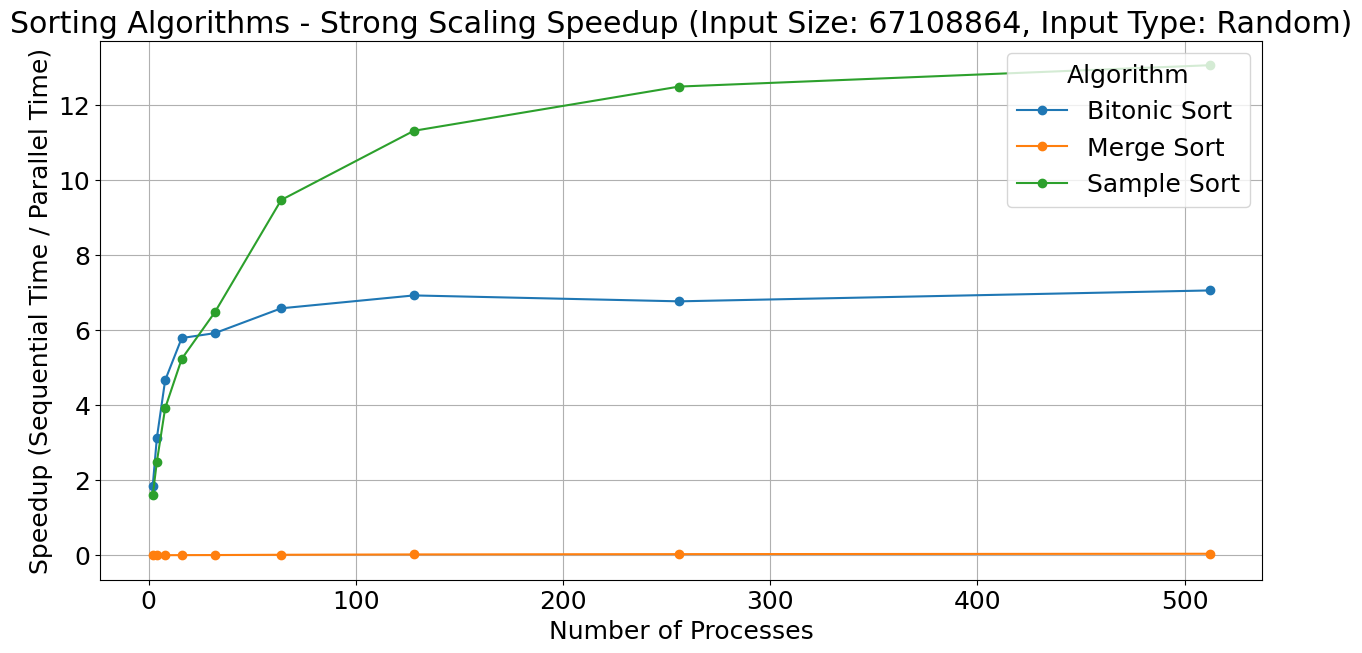

In [17]:
# Plotting the speedup data
plt.figure(figsize=(15, 7))
for alg in algorithms:
    plt.plot(list(speedup_data[alg].keys()), list(speedup_data[alg].values()), marker='o', label=alg.capitalize() + " Sort")

plt.title("Sorting Algorithms - Strong Scaling Speedup (Input Size: 67108864, Input Type: Random)")
plt.xlabel("Number of Processes")
plt.ylabel("Speedup (Sequential Time / Parallel Time)")
plt.grid(True)
plt.legend(title="Algorithm")
plt.savefig(f"./graphs/speedup_67108864_random.png")
plt.show()